## Google Maps API Static Map
衛星写真解析のためにGoogle MapsのStatic Map APIを使ってグリッド分割した画像をDL

In [2]:
import os
import requests
import IPython

In [3]:
api_url = 'https://maps.googleapis.com/maps/api/staticmap'
params = {
    'key': 'api_key_here',
    'size': '230x230',
    'center': '34.98800,135.895000',
    'zoom': '15', # 15
    # 'maptype': 'satellite', # 衛星写真
    # 'maptype': 'roadmap', # 地図
    'maptype': 'hybrid',  # 衛星写真に地図をオーバーラップ
    'style': 'feature:all|element:labels|visibility:off', # 全てのラベルを非表示
    # 'style': 'feature:landscape.man_made|element:geometry.stroke|color:0x0000ff|weight:2|visibility:on',  # 人工建造物を赤線輪郭強調
    # 'style': 'feature:all|element:labels|visibility:off|feature:landscape.man_made|element:geometry.stroke|color:0x0000ff|weight:2|visibility:on',  # 同時指定はダメそう
    'scale': '1',
}

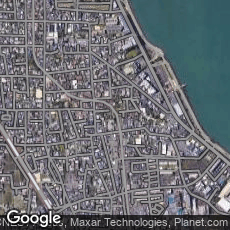

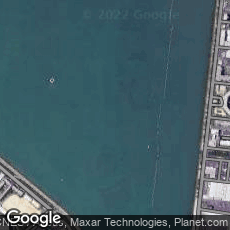

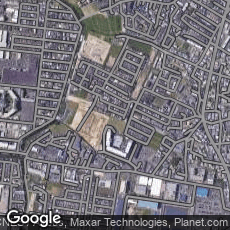

In [4]:
# 滋賀県野洲川付近でテスト

lat = 34.98800
lon = 135.895000

lat_delta = 0.008
lon_delta = 0.01

for i in range(3):
  params['center'] = f'{lat:.6f},{lon:.6f}'
  ret = requests.get(api_url, params=params)
  IPython.display.display(IPython.display.Image(ret.content))

  # lat -= lat_delta
  lon += lon_delta

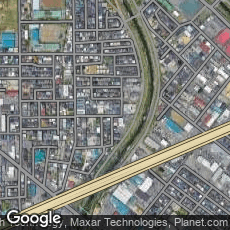

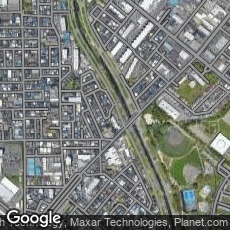

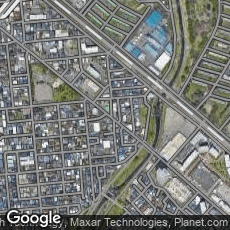

In [254]:
lat = 43.1 #34.98800
lon = 141.3 #135.895000

for i in range(3):
  params['center'] = f'{lat:.6f},{lon:.6f}'
  ret = requests.get(api_url, params=params)
  IPython.display.display(IPython.display.Image(ret.content))

  lat -= 0.008

In [1]:
# 関東圏東部をキャプチャした場合の推定画像枚数
((36.042263 - 35.439601)/0.008) * ((140.028417 - 139.256380)/0.01)

5815.967031174827

## TorchVision ResNet18
グリッド分割した衛星写真データをResNet18に食わせ，  
各画像における512次元特徴ベクトルのコサイン類似度から指定区域に類似するエリアを導き出す

In [147]:
from IPython.display import display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import CosineSimilarity

import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/JPHACKS2022/satellite/'
img_list = []

for f in os.listdir(base_dir):
  img_list.append(Image.open(base_dir + f).convert('RGB'))

In [ ]:
preprocess = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
])
input_images = torch.stack([preprocess(img) for img in img_list])
input_images.shape

torch.Size([9, 3, 224, 224])

In [113]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
feature_extractor = create_feature_extractor(model, {"avgpool": "feature"})

# model(input_img).shape
fea_dict = feature_extractor(input_images)
features = fea_dict['feature']
features.shape

torch.Size([9, 512, 1, 1])

In [154]:
cos_sim = CosineSimilarity(dim=0)
cos_matrix = np.array([[cos_sim(f_0, f_1).detach().numpy().copy()[0][0] for f_1 in features] for f_0 in features])

labels = ['City','Mt.','City','Mt.','Riv','City','R','Riv','Sea']
df = pd.DataFrame(cos_matrix, columns=labels, index=labels)
df[df > 0.999999] = pd.NA
df

,City,Mt.,City,Mt.,Riv,City,R,Riv,Sea
City,NaN,0.562074,0.675988,0.591258,0.665597,0.609388,0.671458,0.659246,0.583631
Mt.,0.562074,NaN,0.542525,0.712000,0.593778,0.538373,0.580530,0.539629,0.538613
City,0.675988,0.542525,NaN,0.584210,0.602342,0.694181,0.683224,0.649076,0.586143
Mt.,0.591258,0.712000,0.584210,NaN,0.666406,0.585316,0.651703,0.655780,0.630587
Riv,0.665597,0.593778,0.602342,0.666406,NaN,0.606512,0.626959,0.665756,0.647329
City,0.609388,0.538373,0.694181,0.585316,0.606512,NaN,0.618583,0.665262,0.600505
R,0.671458,0.580530,0.683224,0.651703,0.626959,0.618583,NaN,0.647610,0.601003
Riv,0.659246,0.539629,0.649076,0.655780,0.665756,0.665262,0.647610,NaN,0.662672
Sea,0.583631,0.538613,0.586143,0.630587,0.647329,0.600505,0.601003,0.662672,NaN


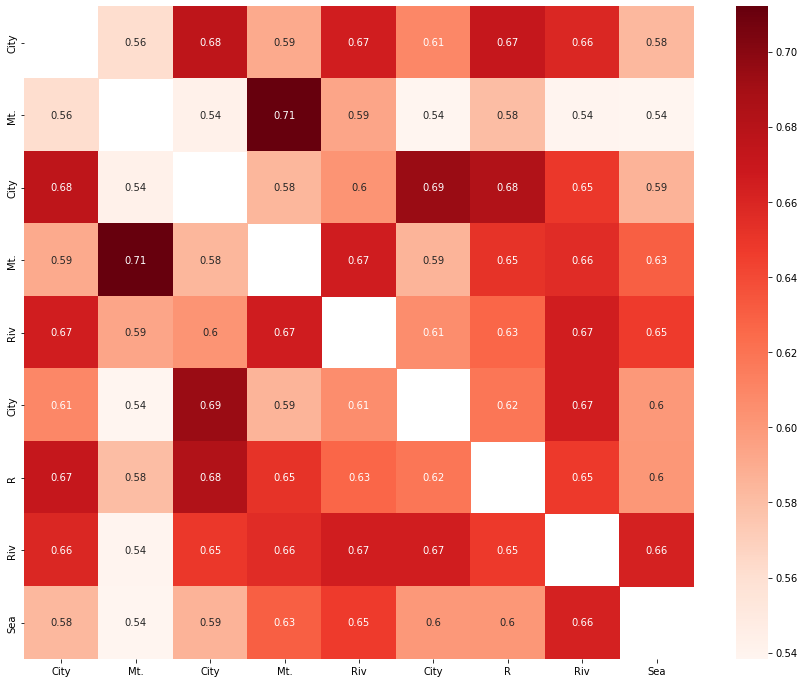

In [151]:
plt.figure(figsize = (15,12))
sns.heatmap(df, annot=True, cmap='Reds')